# AI Základy - Hodiny 26-27: Naivní Bayesův klasifikátor

## Obsah:
1. **Princip fungování Naivního Bayese**
2. **Matematický základ a předpoklady**
3. **Implementace od základů**
4. **Spam filtr - kompletní projekt**
5. **Analýza sentimentu**
6. **Porovnání variant a vyhodnocení**
7. **Interaktivní aplikace**
8. **Domácí úkol**

## 1. Princip fungování Naivního Bayesova klasifikátoru

### 1.1 Základní myšlenka

Naivní Bayesův klasifikátor je pravděpodobnostní klasifikátor založený na Bayesově větě s "naivním" předpokladem podmíněné nezávislosti mezi příznaky.

Pro klasifikaci používáme:
$$P(třída|příznaky) = \frac{P(příznaky|třída) \cdot P(třída)}{P(příznaky)}$$

Klíčový "naivní" předpoklad:
$$P(x_1, x_2, ..., x_n|třída) = P(x_1|třída) \cdot P(x_2|třída) \cdot ... \cdot P(x_n|třída)$$

In [1]:
# Import všech potřebných knihoven
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import re
import string
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Nastavení vizualizace
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

# Pro interaktivní aplikace
import gradio as gr

### 1.2 Vizualizace principu

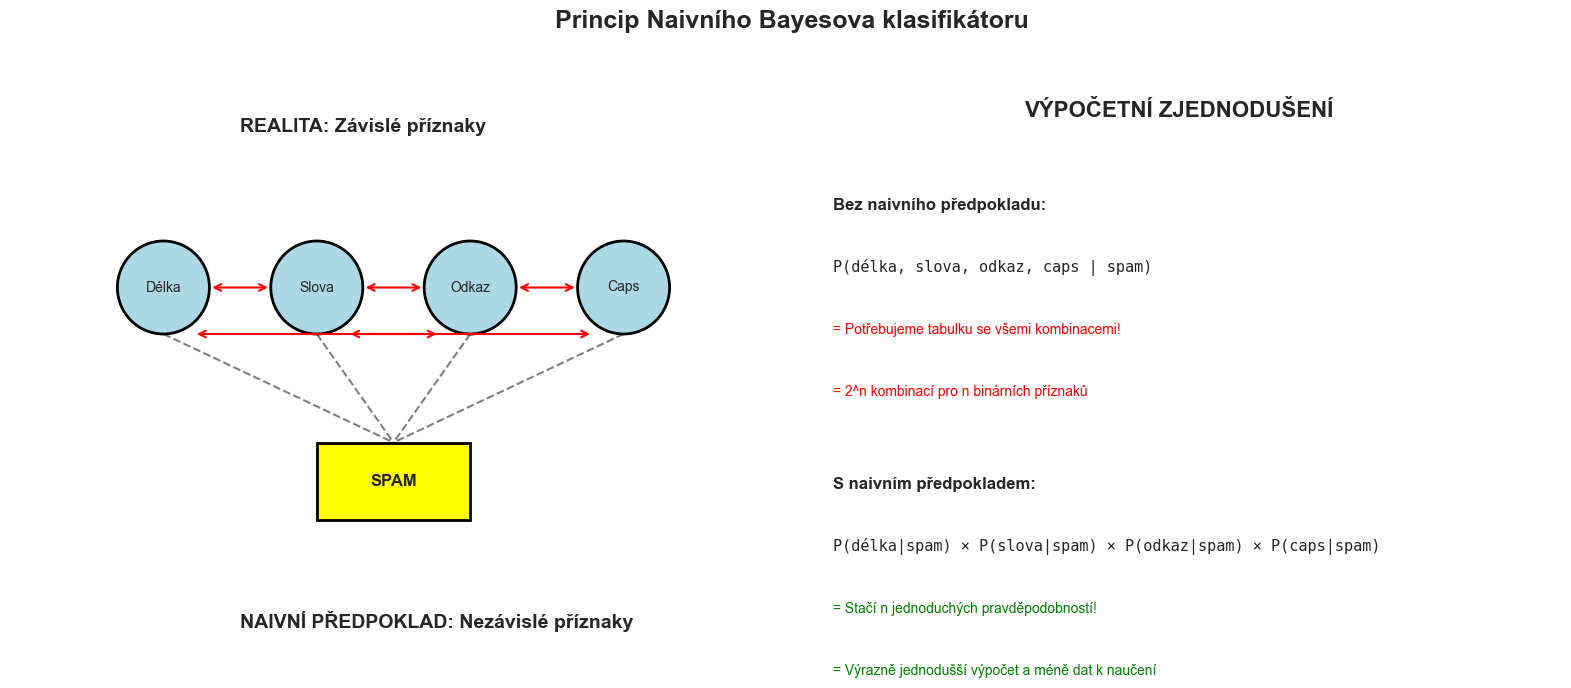

In [2]:
def visualize_naive_bayes_principle():
    """
    Vizualizace principu Naivního Bayese na jednoduchém příkladu
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Graf 1: Závislé vs. nezávislé příznaky
    ax1.set_xlim(-0.5, 5)
    ax1.set_ylim(-0.5, 4)
    
    # Závislé příznaky (realita)
    ax1.text(1, 3.5, 'REALITA: Závislé příznaky', fontsize=14, fontweight='bold')
    
    # Kreslení závislostí
    features = ['Délka', 'Slova', 'Odkaz', 'Caps']
    positions = [(0.5, 2.5), (1.5, 2.5), (2.5, 2.5), (3.5, 2.5)]
    
    for i, (feat, pos) in enumerate(zip(features, positions)):
        circle = plt.Circle(pos, 0.3, color='lightblue', ec='black', linewidth=2)
        ax1.add_patch(circle)
        ax1.text(pos[0], pos[1], feat, ha='center', va='center', fontsize=10)
    
    # Šipky znázorňující závislosti
    dependencies = [
        ((0.8, 2.5), (1.2, 2.5)),
        ((1.8, 2.5), (2.2, 2.5)),
        ((2.8, 2.5), (3.2, 2.5)),
        ((0.7, 2.2), (2.3, 2.2)),
        ((1.7, 2.2), (3.3, 2.2))
    ]
    
    for start, end in dependencies:
        ax1.annotate('', xy=end, xytext=start,
                    arrowprops=dict(arrowstyle='<->', color='red', lw=1.5))
    
    # Třída
    rect = plt.Rectangle((1.5, 1), 1, 0.5, color='yellow', ec='black', linewidth=2)
    ax1.add_patch(rect)
    ax1.text(2, 1.25, 'SPAM', ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Spojnice k třídě
    for pos in positions:
        ax1.plot([pos[0], 2], [pos[1]-0.3, 1.5], 'k--', alpha=0.5)
    
    # Naivní předpoklad
    ax1.text(1, 0.3, 'NAIVNÍ PŘEDPOKLAD: Nezávislé příznaky', 
            fontsize=14, fontweight='bold')
    
    ax1.set_xlim(-0.5, 4.5)
    ax1.set_ylim(0, 4)
    ax1.axis('off')
    
    # Graf 2: Výpočetní zjednodušení
    ax2.text(0.5, 0.9, 'VÝPOČETNÍ ZJEDNODUŠENÍ', 
            ha='center', fontsize=16, fontweight='bold', transform=ax2.transAxes)
    
    # Bez naivního předpokladu
    ax2.text(0.05, 0.75, 'Bez naivního předpokladu:', 
            fontsize=12, fontweight='bold', transform=ax2.transAxes)
    ax2.text(0.05, 0.65, 'P(délka, slova, odkaz, caps | spam)', 
            fontsize=11, transform=ax2.transAxes, family='monospace')
    ax2.text(0.05, 0.55, '= Potřebujeme tabulku se všemi kombinacemi!', 
            fontsize=10, transform=ax2.transAxes, color='red')
    ax2.text(0.05, 0.45, '= 2^n kombinací pro n binárních příznaků', 
            fontsize=10, transform=ax2.transAxes, color='red')
    
    # S naivním předpokladem
    ax2.text(0.05, 0.3, 'S naivním předpokladem:', 
            fontsize=12, fontweight='bold', transform=ax2.transAxes)
    ax2.text(0.05, 0.2, 'P(délka|spam) × P(slova|spam) × P(odkaz|spam) × P(caps|spam)', 
            fontsize=11, transform=ax2.transAxes, family='monospace')
    ax2.text(0.05, 0.1, '= Stačí n jednoduchých pravděpodobností!', 
            fontsize=10, transform=ax2.transAxes, color='green')
    ax2.text(0.05, 0.0, '= Výrazně jednodušší výpočet a méně dat k naučení', 
            fontsize=10, transform=ax2.transAxes, color='green')
    
    ax2.axis('off')
    
    plt.suptitle('Princip Naivního Bayesova klasifikátoru', 
                fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_naive_bayes_principle()

## 2. Matematický základ

### 2.1 Odvození klasifikačního pravidla

Pro klasifikaci hledáme třídu s nejvyšší posteriorní pravděpodobností:

$$\hat{y} = \arg\max_y P(y|x_1, x_2, ..., x_n)$$

Pomocí Bayesovy věty a naivního předpokladu:

$$\hat{y} = \arg\max_y P(y) \prod_{i=1}^n P(x_i|y)$$

In [3]:
# Implementace Naivního Bayese od základů
class NaivniBayes:
    def __init__(self):
        self.class_priors = {}
        self.feature_probs = {}
        self.classes = None
        
    def fit(self, X, y):
        """
        Naučení modelu z trénovacích dat
        """
        self.classes = np.unique(y)
        n_samples = len(y)
        
        # Výpočet priorů pro každou třídu
        for c in self.classes:
            mask = (y == c)
            self.class_priors[c] = np.sum(mask) / n_samples
            
            # Výpočet pravděpodobností příznaků pro každou třídu
            self.feature_probs[c] = {}
            X_class = X[mask]
            
            for feature_idx in range(X.shape[1]):
                # Použití Laplace smoothing
                feature_count = np.sum(X_class[:, feature_idx]) + 1
                total_count = len(X_class) + 2
                self.feature_probs[c][feature_idx] = feature_count / total_count
    
    def predict_proba(self, X):
        """
        Výpočet pravděpodobností pro každou třídu
        """
        probas = []
        
        for x in X:
            class_probas = {}
            
            for c in self.classes:
                # Začínáme s priorem (používáme log pro numerickou stabilitu)
                log_prob = np.log(self.class_priors[c])
                
                # Násobíme pravděpodobnostmi příznaků
                for idx, feature_val in enumerate(x):
                    if feature_val == 1:
                        log_prob += np.log(self.feature_probs[c][idx])
                    else:
                        log_prob += np.log(1 - self.feature_probs[c][idx])
                
                class_probas[c] = np.exp(log_prob)
            
            # Normalizace
            total = sum(class_probas.values())
            class_probas = {c: p/total for c, p in class_probas.items()}
            probas.append(class_probas)
        
        return probas
    
    def predict(self, X):
        """
        Predikce třídy
        """
        probas = self.predict_proba(X)
        predictions = []
        
        for proba in probas:
            predictions.append(max(proba, key=proba.get))
        
        return np.array(predictions)

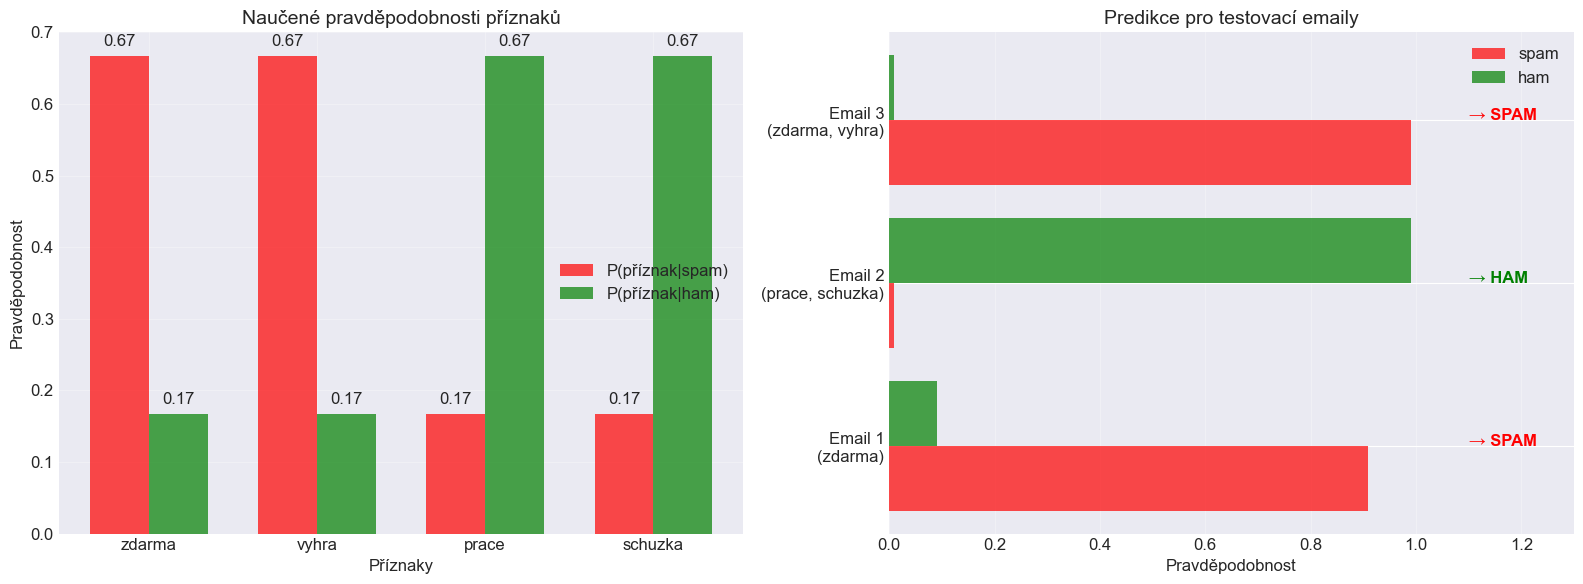

DETAILY NAIVNÍHO BAYESOVA KLASIFIKÁTORU

Naučené priory:
P(spam) = 0.500
P(ham) = 0.500

Testovací predikce:

Email 1: [1 0 0 0]
Predikce: spam
P(spam|email) = 0.909
P(ham|email) = 0.091

Email 2: [0 0 1 1]
Predikce: ham
P(spam|email) = 0.010
P(ham|email) = 0.990

Email 3: [1 1 0 0]
Predikce: spam
P(spam|email) = 0.990
P(ham|email) = 0.010


In [4]:
# Ukázka na jednoduchém příkladu
def simple_naive_bayes_demo():
    # Vytvoření jednoduchého datasetu - emaily
    # Příznaky: [obsahuje "zdarma", obsahuje "vyhra", obsahuje "prace", obsahuje "schuzka"]
    X_train = np.array([
        [1, 1, 0, 0],  # spam
        [1, 0, 0, 0],  # spam
        [0, 1, 0, 0],  # spam
        [1, 1, 0, 0],  # spam
        [0, 0, 1, 1],  # ham
        [0, 0, 1, 0],  # ham
        [0, 0, 0, 1],  # ham
        [0, 0, 1, 1],  # ham
    ])
    
    y_train = np.array(['spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham'])
    
    # Trénování vlastní implementace
    nb = NaivniBayes()
    nb.fit(X_train, y_train)
    
    # Testovací data
    X_test = np.array([
        [1, 0, 0, 0],  # obsahuje "zdarma"
        [0, 0, 1, 1],  # obsahuje "prace" a "schuzka"
        [1, 1, 0, 0],  # obsahuje "zdarma" a "vyhra"
    ])
    
    # Predikce
    predictions = nb.predict(X_test)
    probabilities = nb.predict_proba(X_test)
    
    # Vizualizace výsledků
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Graf 1: Naučené parametry
    features = ['zdarma', 'vyhra', 'prace', 'schuzka']
    spam_probs = [nb.feature_probs['spam'][i] for i in range(4)]
    ham_probs = [nb.feature_probs['ham'][i] for i in range(4)]
    
    x = np.arange(len(features))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, spam_probs, width, label='P(příznak|spam)', 
                    color='red', alpha=0.7)
    bars2 = ax1.bar(x + width/2, ham_probs, width, label='P(příznak|ham)', 
                    color='green', alpha=0.7)
    
    ax1.set_ylabel('Pravděpodobnost')
    ax1.set_xlabel('Příznaky')
    ax1.set_title('Naučené pravděpodobnosti příznaků', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(features)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Přidání hodnot
    for bars, probs in [(bars1, spam_probs), (bars2, ham_probs)]:
        for bar, prob in zip(bars, probs):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{prob:.2f}', ha='center', va='bottom')
    
    # Graf 2: Výsledky predikce
    test_labels = ['Email 1\n(zdarma)', 'Email 2\n(prace, schuzka)', 'Email 3\n(zdarma, vyhra)']
    
    for i, (label, pred, probs) in enumerate(zip(test_labels, predictions, probabilities)):
        spam_prob = probs.get('spam', 0)
        ham_prob = probs.get('ham', 0)
        
        ax2.barh(i*2, spam_prob, color='red', alpha=0.7, label='spam' if i == 0 else '')
        ax2.barh(i*2+0.8, ham_prob, color='green', alpha=0.7, label='ham' if i == 0 else '')
        
        # Označení predikce
        ax2.text(1.1, i*2+0.4, f'→ {pred.upper()}', fontsize=12, fontweight='bold',
                color='red' if pred == 'spam' else 'green')
    
    ax2.set_yticks([0.4, 2.4, 4.4])
    ax2.set_yticklabels(test_labels)
    ax2.set_xlabel('Pravděpodobnost')
    ax2.set_title('Predikce pro testovací emaily', fontsize=14)
    ax2.legend()
    ax2.set_xlim(0, 1.3)
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Výpis detailů
    print("="*60)
    print("DETAILY NAIVNÍHO BAYESOVA KLASIFIKÁTORU")
    print("="*60)
    print(f"\nNaučené priory:")
    print(f"P(spam) = {nb.class_priors['spam']:.3f}")
    print(f"P(ham) = {nb.class_priors['ham']:.3f}")
    
    print("\nTestovací predikce:")
    for i, (features, pred, probs) in enumerate(zip(X_test, predictions, probabilities)):
        print(f"\nEmail {i+1}: {features}")
        print(f"Predikce: {pred}")
        print(f"P(spam|email) = {probs.get('spam', 0):.3f}")
        print(f"P(ham|email) = {probs.get('ham', 0):.3f}")

simple_naive_bayes_demo()

## 3. Varianty Naivního Bayese

### 3.1 Podle typu dat

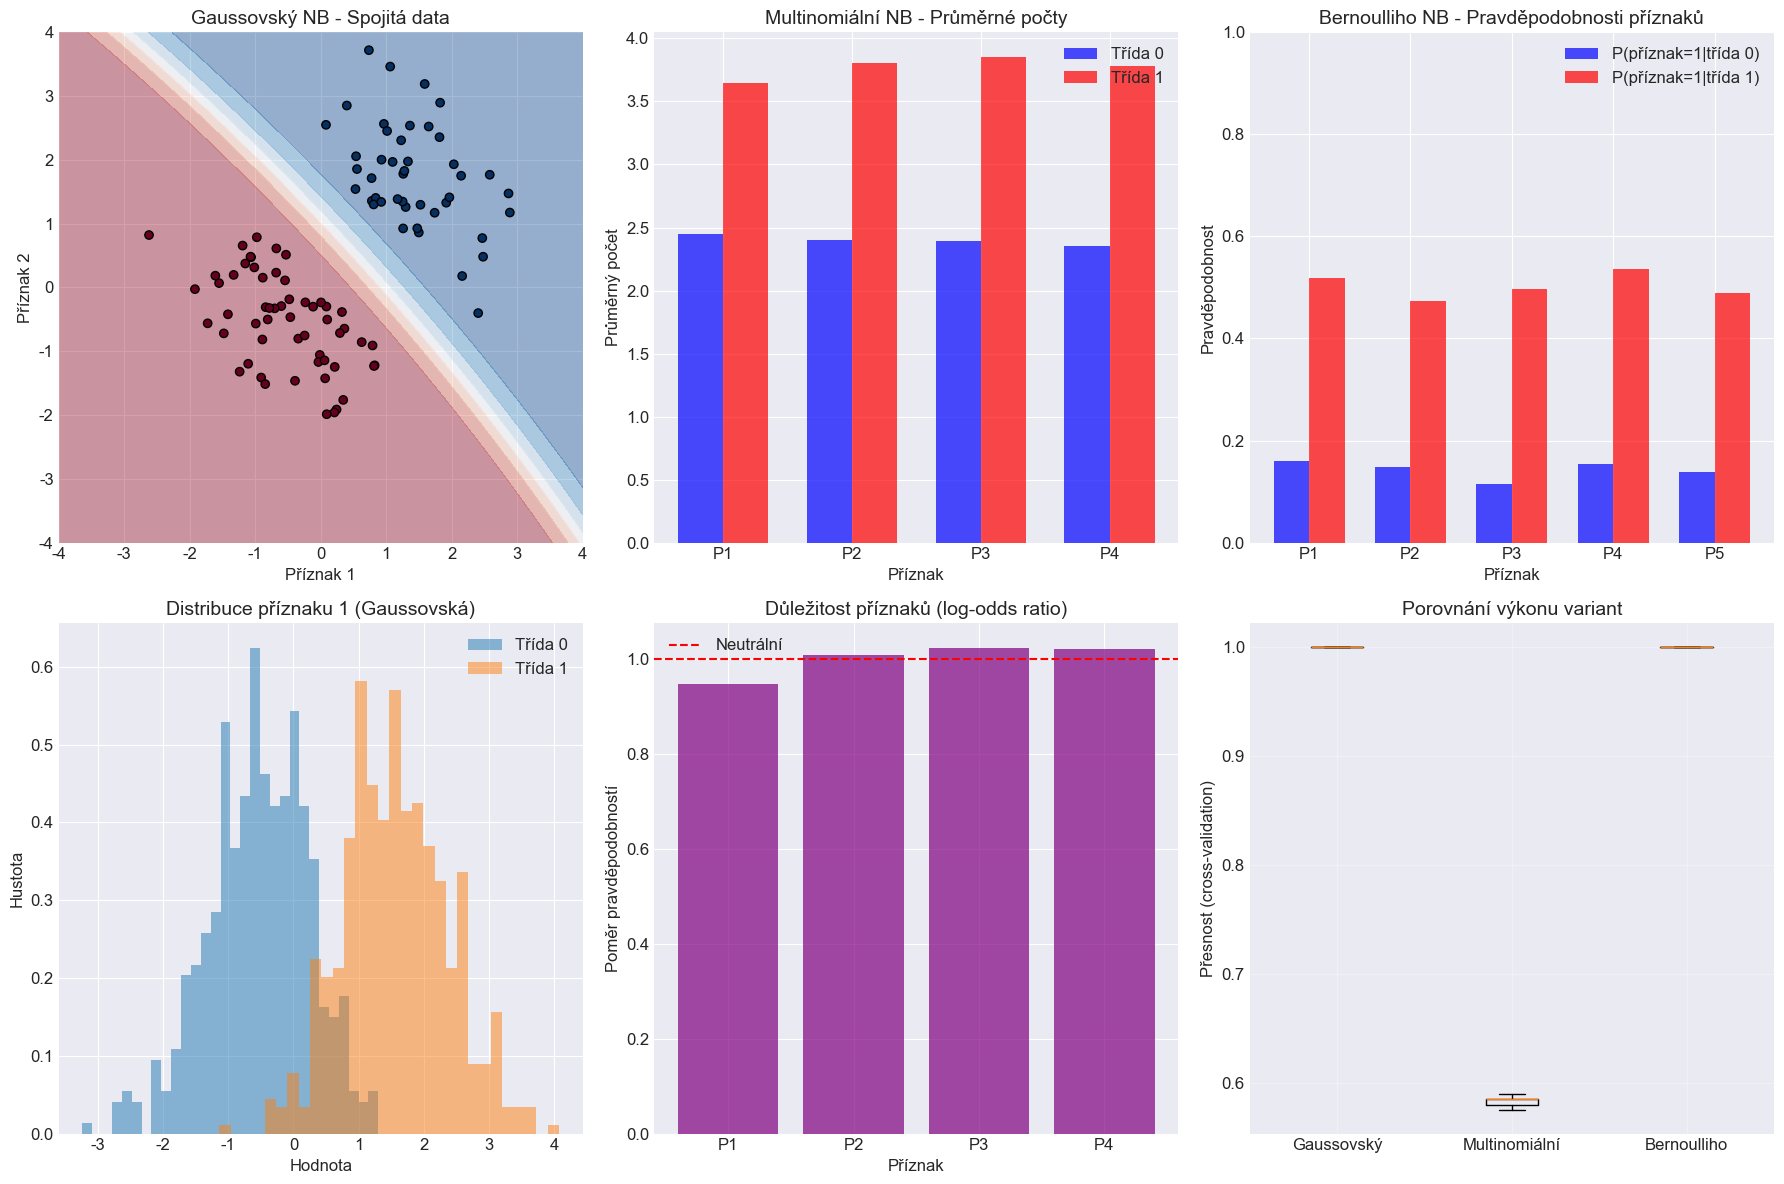

VARIANTY NAIVNÍHO BAYESOVA KLASIFIKÁTORU

1. GAUSSOVSKÝ NB:
   - Pro spojité příznaky
   - Předpokládá normální rozdělení
   - Vhodný pro: výška, váha, teplota, atd.

2. MULTINOMIÁLNÍ NB:
   - Pro diskrétní počty
   - Modeluje četnosti výskytu
   - Vhodný pro: počty slov v textu, frekvence

3. BERNOULLIHO NB:
   - Pro binární příznaky
   - Modeluje přítomnost/nepřítomnost
   - Vhodný pro: binární příznaky, přítomnost slov


In [5]:
# Demonstrace různých variant Naivního Bayese
def demonstrate_naive_bayes_variants():
    # Generování různých typů dat
    np.random.seed(42)
    n_samples = 1000
    
    # 1. Gaussovská data (spojitá)
    X_gaussian = np.random.randn(n_samples, 2)
    y_gaussian = (X_gaussian[:, 0] + X_gaussian[:, 1] > 0).astype(int)
    X_gaussian[y_gaussian == 1] += [1, 1]
    
    # 2. Multinomiální data (počty)
    X_multinomial = np.random.poisson(3, size=(n_samples, 4))
    y_multinomial = (X_multinomial.sum(axis=1) > 12).astype(int)
    
    # 3. Bernoulliho data (binární)
    X_bernoulli = np.random.binomial(1, 0.3, size=(n_samples, 5))
    y_bernoulli = (X_bernoulli.sum(axis=1) >= 2).astype(int)
    
    # Vizualizace
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Gaussovský NB
    gnb = GaussianNB()
    gnb.fit(X_gaussian, y_gaussian)
    
    # Vizualizace rozhodovací hranice
    xx, yy = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
    Z = gnb.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    
    axes[0, 0].contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    axes[0, 0].scatter(X_gaussian[:100, 0], X_gaussian[:100, 1], 
                      c=y_gaussian[:100], cmap='RdBu', edgecolors='black')
    axes[0, 0].set_title('Gaussovský NB - Spojitá data', fontsize=14)
    axes[0, 0].set_xlabel('Příznak 1')
    axes[0, 0].set_ylabel('Příznak 2')
    
    # Distribuce příznaků pro Gaussovský NB
    for class_idx in [0, 1]:
        mask = y_gaussian == class_idx
        axes[1, 0].hist(X_gaussian[mask, 0], bins=30, alpha=0.5, 
                       label=f'Třída {class_idx}', density=True)
    
    axes[1, 0].set_title('Distribuce příznaku 1 (Gaussovská)', fontsize=14)
    axes[1, 0].set_xlabel('Hodnota')
    axes[1, 0].set_ylabel('Hustota')
    axes[1, 0].legend()
    
    # Multinomiální NB
    mnb = MultinomialNB()
    mnb.fit(X_multinomial, y_multinomial)
    
    # Průměrné počty pro každou třídu
    mean_counts = []
    for class_idx in [0, 1]:
        mask = y_multinomial == class_idx
        mean_counts.append(X_multinomial[mask].mean(axis=0))
    
    x = np.arange(4)
    width = 0.35
    
    bars1 = axes[0, 1].bar(x - width/2, mean_counts[0], width, 
                          label='Třída 0', color='blue', alpha=0.7)
    bars2 = axes[0, 1].bar(x + width/2, mean_counts[1], width, 
                          label='Třída 1', color='red', alpha=0.7)
    
    axes[0, 1].set_title('Multinomiální NB - Průměrné počty', fontsize=14)
    axes[0, 1].set_xlabel('Příznak')
    axes[0, 1].set_ylabel('Průměrný počet')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels([f'P{i+1}' for i in range(4)])
    axes[0, 1].legend()
    
    # Feature importance pro Multinomiální NB
    feature_log_prob = mnb.feature_log_prob_
    importance = np.exp(feature_log_prob[1] - feature_log_prob[0])
    
    axes[1, 1].bar(x, importance, color='purple', alpha=0.7)
    axes[1, 1].axhline(y=1, color='red', linestyle='--', label='Neutrální')
    axes[1, 1].set_title('Důležitost příznaků (log-odds ratio)', fontsize=14)
    axes[1, 1].set_xlabel('Příznak')
    axes[1, 1].set_ylabel('Poměr pravděpodobností')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels([f'P{i+1}' for i in range(4)])
    axes[1, 1].legend()
    
    # Bernoulliho NB
    bnb = BernoulliNB()
    bnb.fit(X_bernoulli, y_bernoulli)
    
    # Pravděpodobnosti příznaků
    feature_probs = np.exp(bnb.feature_log_prob_)
    
    x = np.arange(5)
    bars1 = axes[0, 2].bar(x - width/2, feature_probs[0], width, 
                          label='P(příznak=1|třída 0)', color='blue', alpha=0.7)
    bars2 = axes[0, 2].bar(x + width/2, feature_probs[1], width, 
                          label='P(příznak=1|třída 1)', color='red', alpha=0.7)
    
    axes[0, 2].set_title('Bernoulliho NB - Pravděpodobnosti příznaků', fontsize=14)
    axes[0, 2].set_xlabel('Příznak')
    axes[0, 2].set_ylabel('Pravděpodobnost')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels([f'P{i+1}' for i in range(5)])
    axes[0, 2].legend()
    axes[0, 2].set_ylim(0, 1)
    
    # Výkon různých variant
    variants = [
        ('Gaussovský', gnb, X_gaussian, y_gaussian),
        ('Multinomiální', mnb, X_multinomial, y_multinomial),
        ('Bernoulliho', bnb, X_bernoulli, y_bernoulli)
    ]
    
    scores = []
    for name, model, X, y in variants:
        cv_scores = cross_val_score(model, X, y, cv=5)
        scores.append(cv_scores)
    
    axes[1, 2].boxplot(scores, labels=[v[0] for v in variants])
    axes[1, 2].set_title('Porovnání výkonu variant', fontsize=14)
    axes[1, 2].set_ylabel('Přesnost (cross-validation)')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Shrnutí
    print("="*70)
    print("VARIANTY NAIVNÍHO BAYESOVA KLASIFIKÁTORU")
    print("="*70)
    print("\n1. GAUSSOVSKÝ NB:")
    print("   - Pro spojité příznaky")
    print("   - Předpokládá normální rozdělení")
    print("   - Vhodný pro: výška, váha, teplota, atd.")
    
    print("\n2. MULTINOMIÁLNÍ NB:")
    print("   - Pro diskrétní počty")
    print("   - Modeluje četnosti výskytu")
    print("   - Vhodný pro: počty slov v textu, frekvence")
    
    print("\n3. BERNOULLIHO NB:")
    print("   - Pro binární příznaky")
    print("   - Modeluje přítomnost/nepřítomnost")
    print("   - Vhodný pro: binární příznaky, přítomnost slov")

demonstrate_naive_bayes_variants()

## 4. Spam filtr - kompletní implementace

### 4.1 Příprava dat

In [6]:
# Vytvoření datasetu emailů
def create_email_dataset():
    # Simulace emailových dat
    spam_emails = [
        "Vyhrajte penize zdarma! Kliknete zde ihned!",
        "Gratulujeme! Vyhráli jste 1 milion Kč! Volejte nyní!",
        "Speciální nabídka pouze dnes! Sleva 90% na všechno!",
        "ZDARMA ZDARMA ZDARMA! Objednejte si náš produkt!",
        "Rychlé peníze! Vydělávejte tisíce denně z domova!",
        "Tato nabídka vyprší za 24 hodin! Jednejte rychle!",
        "Klikněte zde pro okamžité schválení úvěru!",
        "Staňte se milionářem během týdne! 100% zaručeno!",
        "Exkluzivní nabídka jen pro vás! Omezeně!",
        "POZOR! Váš účet bude zrušen! Klikněte pro obnovení!"
    ] * 10  # Zvětšíme dataset
    
    ham_emails = [
        "Dobrý den, posílám vám report z minulého týdne.",
        "Schůzka je naplánována na zítra v 10:00.",
        "Děkuji za váš email. Odpovím co nejdříve.",
        "Projekt postupuje podle plánu. Dokumentace je přiložena.",
        "Můžeme se sejít příští týden ohledně nové zakázky?",
        "Přeposílám informace z porady. Prosím o komentáře.",
        "Rozpočet na příští kvartál je v příloze.",
        "Tým dokončil implementaci nové funkcionality.",
        "Prosím o schválení následujících změn v projektu.",
        "Zítra budu pracovat z domova. Jsem dostupný na telefonu."
    ] * 10
    
    # Kombinace a označení
    emails = spam_emails + ham_emails
    labels = ['spam'] * len(spam_emails) + ['ham'] * len(ham_emails)
    
    # Zamíchání
    indices = np.random.permutation(len(emails))
    emails = [emails[i] for i in indices]
    labels = [labels[i] for i in indices]
    
    return emails, labels

# Předzpracování textu
def preprocess_text(text):
    # Převod na malá písmena
    text = text.lower()
    # Odstranění interpunkce
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    # Odstranění číslic
    text = re.sub(r'\d+', '', text)
    # Odstranění extra mezer
    text = ' '.join(text.split())
    return text

# Vytvoření datasetu
emails, labels = create_email_dataset()
print(f"Vytvořeno {len(emails)} emailů ({labels.count('spam')} spam, {labels.count('ham')} ham)")
print("\nUkázka emailů:")
print("SPAM:", emails[labels.index('spam')])
print("HAM:", emails[labels.index('ham')])

Vytvořeno 200 emailů (100 spam, 100 ham)

Ukázka emailů:
SPAM: Exkluzivní nabídka jen pro vás! Omezeně!
HAM: Dobrý den, posílám vám report z minulého týdne.


### 4.2 Implementace spam filtru

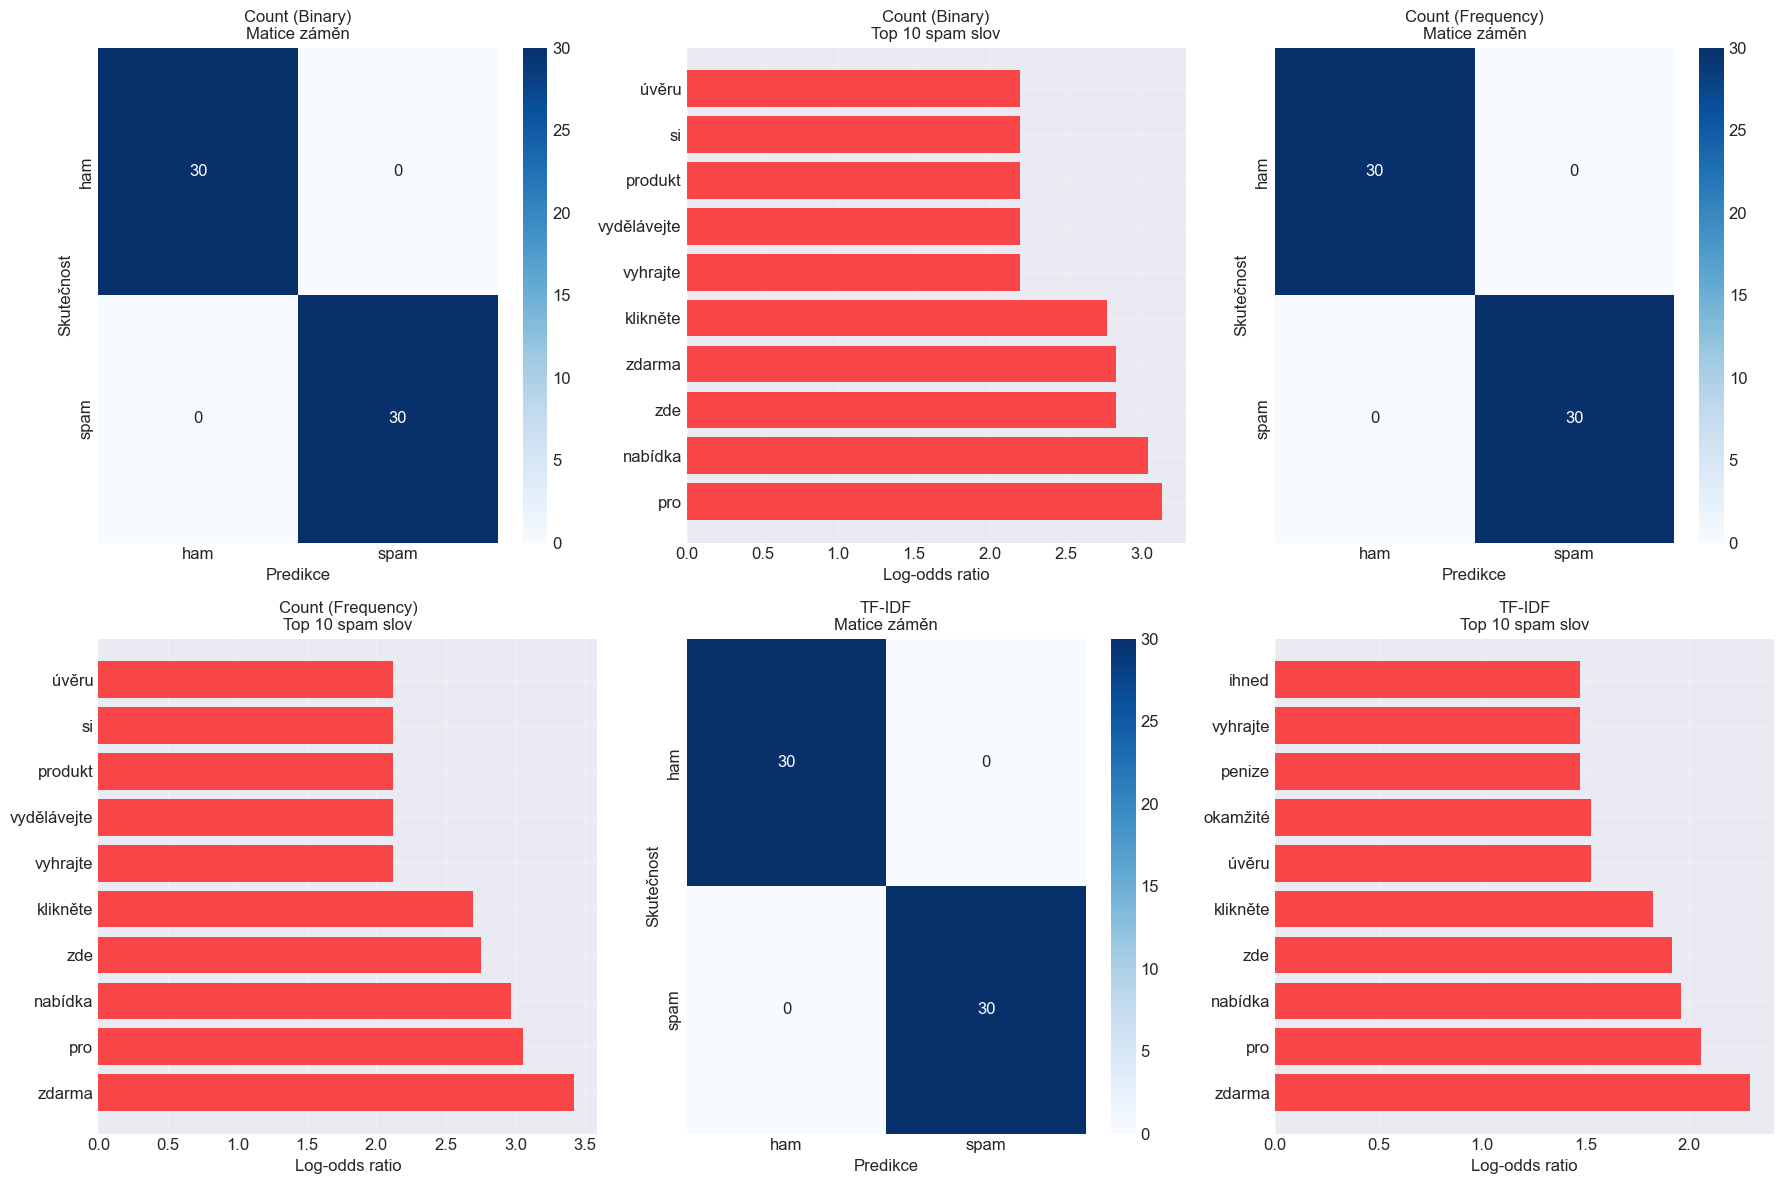

VÝSLEDKY SPAM FILTRU

Count (Binary):
  Přesnost: 100.00%

Klasifikační report:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00        30
        spam       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


Count (Frequency):
  Přesnost: 100.00%

Klasifikační report:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00        30
        spam       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


TF-IDF:
  Přesnost: 100.00%

Klasifikační report:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00        30
        spam       1.00      1.00      1.00 

In [7]:
# Kompletní spam filtr s různými přístupy
def build_spam_filter():
    # Získání dat
    emails, labels = create_email_dataset()
    
    # Předzpracování
    processed_emails = [preprocess_text(email) for email in emails]
    
    # Rozdělení na trénovací a testovací
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        processed_emails, labels, test_size=0.3, random_state=42, stratify=labels
    )
    
    # Různé způsoby vektorizace
    vectorizers = {
        'Count (Binary)': CountVectorizer(binary=True, max_features=100),
        'Count (Frequency)': CountVectorizer(binary=False, max_features=100),
        'TF-IDF': TfidfVectorizer(max_features=100)
    }
    
    results = {}
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for idx, (vec_name, vectorizer) in enumerate(vectorizers.items()):
        # Vektorizace
        X_train = vectorizer.fit_transform(X_train_text)
        X_test = vectorizer.transform(X_test_text)
        
        # Výběr vhodného NB klasifikátoru
        if vec_name == 'Count (Binary)':
            clf = BernoulliNB()
        elif vec_name == 'TF-IDF':
            clf = MultinomialNB()  # TF-IDF values are non-negative
        else:
            clf = MultinomialNB()
        
        # Trénování
        clf.fit(X_train, y_train)
        
        # Predikce
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Uložení výsledků
        results[vec_name] = {
            'vectorizer': vectorizer,
            'classifier': clf,
            'accuracy': accuracy,
            'predictions': y_pred
        }
        
        # Matice záměn
        cm = confusion_matrix(y_test, y_pred, labels=['ham', 'spam'])
        
        # Vizualizace matice záměn
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['ham', 'spam'],
                   yticklabels=['ham', 'spam'],
                   ax=axes[idx*2])
        axes[idx*2].set_title(f'{vec_name}\nMatice záměn', fontsize=12)
        axes[idx*2].set_ylabel('Skutečnost')
        axes[idx*2].set_xlabel('Predikce')
        
        # Top slova pro spam
        if hasattr(clf, 'feature_log_prob_'):
            feature_names = vectorizer.get_feature_names_out()
            
            # Log-odds ratio pro spam vs ham
            log_odds = clf.feature_log_prob_[1] - clf.feature_log_prob_[0]
            indices = np.argsort(log_odds)[::-1]
            
            # Top 10 spam slov
            top_spam_indices = indices[:10]
            top_spam_words = [feature_names[i] for i in top_spam_indices]
            top_spam_scores = [log_odds[i] for i in top_spam_indices]
            
            axes[idx*2+1].barh(range(10), top_spam_scores, color='red', alpha=0.7)
            axes[idx*2+1].set_yticks(range(10))
            axes[idx*2+1].set_yticklabels(top_spam_words)
            axes[idx*2+1].set_xlabel('Log-odds ratio')
            axes[idx*2+1].set_title(f'{vec_name}\nTop 10 spam slov', fontsize=12)
            axes[idx*2+1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Souhrn výsledků
    print("="*70)
    print("VÝSLEDKY SPAM FILTRU")
    print("="*70)
    for name, res in results.items():
        print(f"\n{name}:")
        print(f"  Přesnost: {res['accuracy']:.2%}")
        
        # Klasifikační report
        print("\nKlasifikační report:")
        print(classification_report(y_test, res['predictions'], 
                                  target_names=['ham', 'spam']))
    
    return results

# Spuštění spam filtru
spam_filter_results = build_spam_filter()

### 4.3 Testování na nových emailech

Používám nejlepší model: Count (Binary) (přesnost: 100.00%)


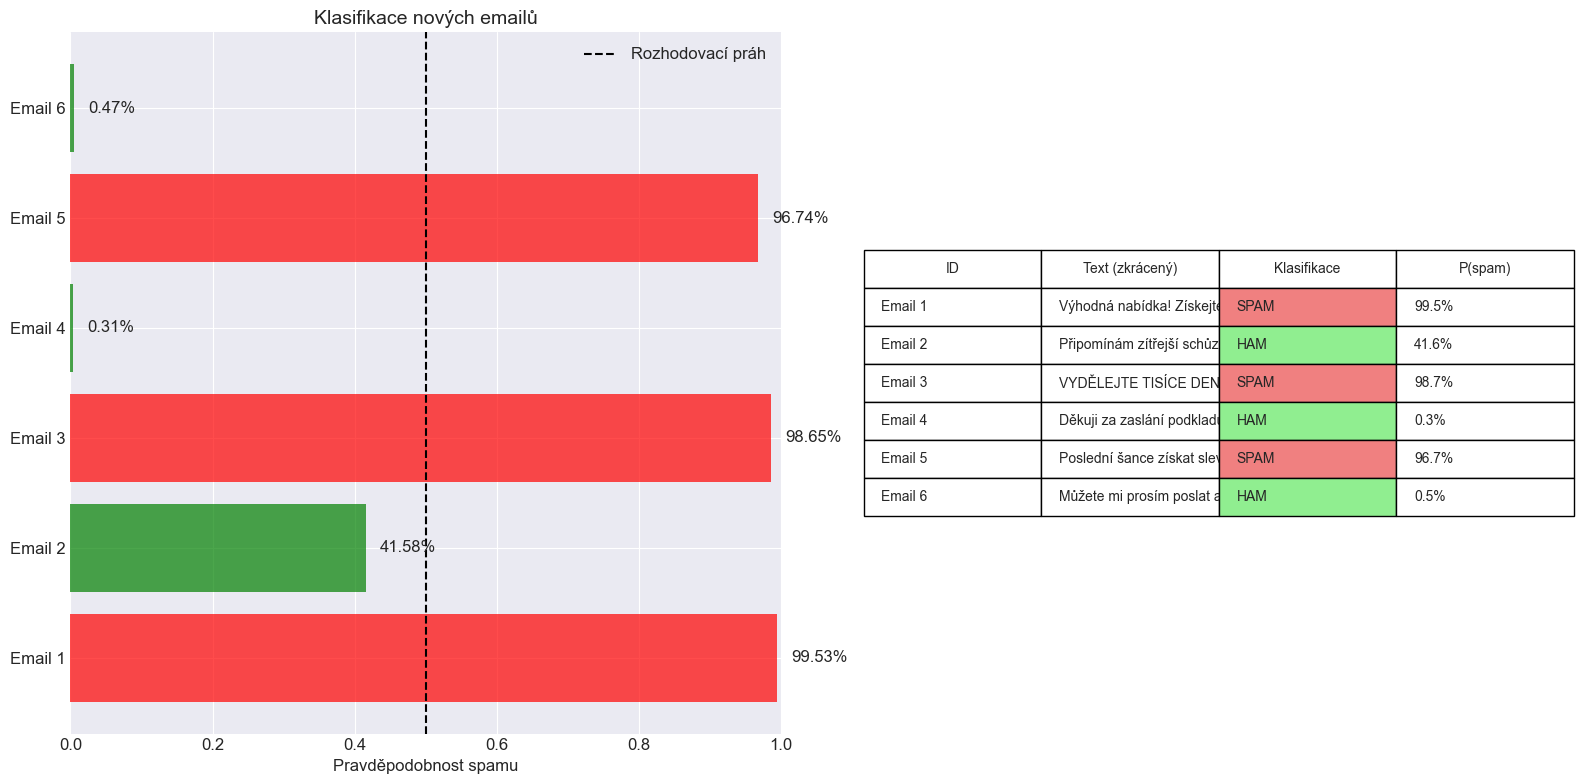


DETAILNÍ KLASIFIKACE

Email 1: Výhodná nabídka! Získejte úvěr ihned bez ručitele!
Klasifikace: SPAM
Pravděpodobnost spamu: 99.53%
Důvěra v klasifikaci: 99.53%

Email 2: Připomínám zítřejší schůzku v 14:00 v zasedací místnosti.
Klasifikace: HAM
Pravděpodobnost spamu: 41.58%
Důvěra v klasifikaci: 58.42%

Email 3: VYDĚLEJTE TISÍCE DENNĚ! Pracujte z domova!
Klasifikace: SPAM
Pravděpodobnost spamu: 98.65%
Důvěra v klasifikaci: 98.65%

Email 4: Děkuji za zaslání podkladů. Projdu je a ozvu se.
Klasifikace: HAM
Pravděpodobnost spamu: 0.31%
Důvěra v klasifikaci: 99.69%

Email 5: Poslední šance získat slevu 80%! Pouze dnes!
Klasifikace: SPAM
Pravděpodobnost spamu: 96.74%
Důvěra v klasifikaci: 96.74%

Email 6: Můžete mi prosím poslat aktualizovaný rozpočet?
Klasifikace: HAM
Pravděpodobnost spamu: 0.47%
Důvěra v klasifikaci: 99.53%


In [8]:
# Funkce pro klasifikaci nových emailů
def classify_new_emails(results):
    # Výběr nejlepšího modelu
    best_model_name = max(results, key=lambda x: results[x]['accuracy'])
    best_model = results[best_model_name]
    
    print(f"Používám nejlepší model: {best_model_name} (přesnost: {best_model['accuracy']:.2%})")
    
    # Nové testovací emaily
    new_emails = [
        "Výhodná nabídka! Získejte úvěr ihned bez ručitele!",
        "Připomínám zítřejší schůzku v 14:00 v zasedací místnosti.",
        "VYDĚLEJTE TISÍCE DENNĚ! Pracujte z domova!",
        "Děkuji za zaslání podkladů. Projdu je a ozvu se.",
        "Poslední šance získat slevu 80%! Pouze dnes!",
        "Můžete mi prosím poslat aktualizovaný rozpočet?"
    ]
    
    # Klasifikace
    vectorizer = best_model['vectorizer']
    classifier = best_model['classifier']
    
    processed_new = [preprocess_text(email) for email in new_emails]
    X_new = vectorizer.transform(processed_new)
    
    predictions = classifier.predict(X_new)
    probabilities = classifier.predict_proba(X_new)
    
    # Vizualizace výsledků
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Graf 1: Pravděpodobnosti pro každý email
    email_labels = [f"Email {i+1}" for i in range(len(new_emails))]
    spam_probs = probabilities[:, 1]  # Pravděpodobnost spamu
    
    colors = ['red' if pred == 'spam' else 'green' for pred in predictions]
    bars = ax1.barh(email_labels, spam_probs, color=colors, alpha=0.7)
    
    ax1.axvline(x=0.5, color='black', linestyle='--', label='Rozhodovací práh')
    ax1.set_xlabel('Pravděpodobnost spamu')
    ax1.set_title('Klasifikace nových emailů', fontsize=14)
    ax1.set_xlim(0, 1)
    ax1.legend()
    
    # Přidání hodnot
    for bar, prob in zip(bars, spam_probs):
        width = bar.get_width()
        ax1.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                f'{prob:.2%}', ha='left', va='center')
    
    # Graf 2: Detaily emailů
    ax2.axis('tight')
    ax2.axis('off')
    
    # Vytvoření tabulky s výsledky
    table_data = []
    for i, (email, pred, prob) in enumerate(zip(new_emails, predictions, spam_probs)):
        # Zkrácení emailu pro zobrazení
        short_email = email[:50] + '...' if len(email) > 50 else email
        table_data.append([
            f"Email {i+1}",
            short_email,
            pred.upper(),
            f"{prob:.1%}"
        ])
    
    table = ax2.table(cellText=table_data,
                     colLabels=['ID', 'Text (zkrácený)', 'Klasifikace', 'P(spam)'],
                     cellLoc='left',
                     loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Obarvení podle klasifikace
    for i in range(1, len(table_data) + 1):
        if predictions[i-1] == 'spam':
            table[(i, 2)].set_facecolor('lightcoral')
        else:
            table[(i, 2)].set_facecolor('lightgreen')
    
    plt.tight_layout()
    plt.show()
    
    # Detailní výpis
    print("\n" + "="*70)
    print("DETAILNÍ KLASIFIKACE")
    print("="*70)
    for i, (email, pred, prob) in enumerate(zip(new_emails, predictions, spam_probs)):
        print(f"\nEmail {i+1}: {email}")
        print(f"Klasifikace: {pred.upper()}")
        print(f"Pravděpodobnost spamu: {prob:.2%}")
        print(f"Důvěra v klasifikaci: {max(prob, 1-prob):.2%}")

# Test nových emailů
classify_new_emails(spam_filter_results)

## 5. Analýza sentimentu

### 5.1 Implementace analýzy sentimentu

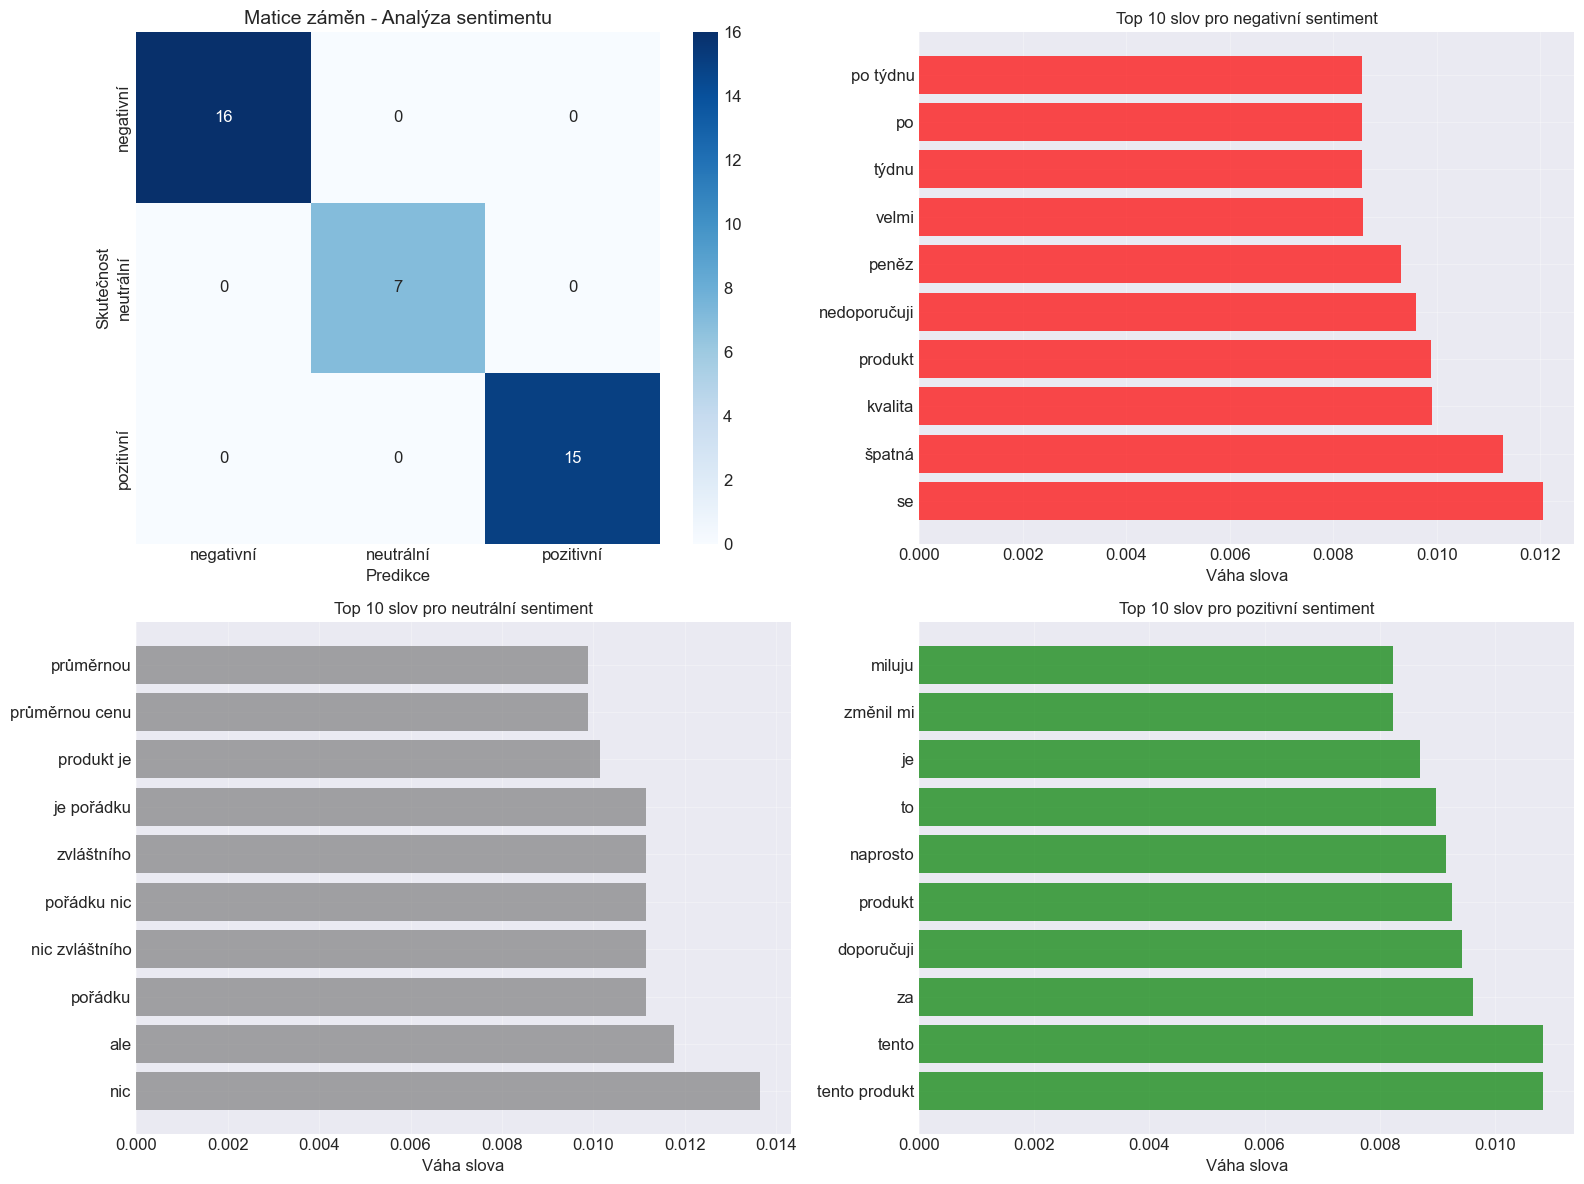

VÝSLEDKY ANALÝZY SENTIMENTU

Celková přesnost: 100.00%

Klasifikační report:
              precision    recall  f1-score   support

   negativní       1.00      1.00      1.00        16
   neutrální       1.00      1.00      1.00         7
   pozitivní       1.00      1.00      1.00        15

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



In [9]:
# Vytvoření datasetu pro analýzu sentimentu
def create_sentiment_dataset():
    # Pozitivní recenze
    positive_reviews = [
        "Tento produkt je naprosto úžasný! Velmi doporučuji!",
        "Skvělá kvalita za rozumnou cenu. Jsem velmi spokojený.",
        "Překonal moje očekávání. Funguje perfektně!",
        "Nejlepší nákup za poslední dobu. Děkuji!",
        "Výborný produkt, rychlé dodání. Super zkušenost.",
        "Naprosto spokojený zákazník. Budu kupovat znovu.",
        "Kvalita je fantastická. Stojí to za každou korunu.",
        "Miluju tento produkt! Změnil mi život.",
        "Profesionální přístup a skvělý výsledek.",
        "Doporučuji všem! Nemá to chybu."
    ] * 5
    
    # Negativní recenze
    negative_reviews = [
        "Zklamání. Produkt nefunguje jak má.",
        "Špatná kvalita. Rozbilo se po týdnu.",
        "Nejhorší nákup ever. Vyhozené peníze.",
        "Nedoporučuji. Velmi špatná zkušenost.",
        "Produkt neodpovídá popisu. Cítím se podveden.",
        "Hrozná kvalita za přemrštěnou cenu.",
        "Nefunkční produkt. Žádám o vrácení peněz.",
        "Katastrofa. Už nikdy více od této firmy.",
        "Ztráta času a peněz. Velmi zklamán.",
        "Nedoporučuji nikomu. Absolutní propadák."
    ] * 5
    
    # Neutrální recenze
    neutral_reviews = [
        "Produkt je v pořádku. Nic zvláštního.",
        "Splňuje účel, ale nic víc.",
        "Průměrná kvalita za průměrnou cenu.",
        "Funguje jak má, ale nejsem nadšený.",
        "Standardní produkt bez překvapení."
    ] * 5
    
    # Kombinace
    reviews = positive_reviews + negative_reviews + neutral_reviews
    sentiments = (['pozitivní'] * len(positive_reviews) + 
                 ['negativní'] * len(negative_reviews) + 
                 ['neutrální'] * len(neutral_reviews))
    
    # Zamíchání
    indices = np.random.permutation(len(reviews))
    reviews = [reviews[i] for i in indices]
    sentiments = [sentiments[i] for i in indices]
    
    return reviews, sentiments

# Analýza sentimentu s vizualizací
def sentiment_analysis():
    # Získání dat
    reviews, sentiments = create_sentiment_dataset()
    
    # Předzpracování
    processed_reviews = [preprocess_text(review) for review in reviews]
    
    # Rozdělení dat
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        processed_reviews, sentiments, test_size=0.3, random_state=42
    )
    
    # Vektorizace s n-gramy
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=200)
    X_train = vectorizer.fit_transform(X_train_text)
    X_test = vectorizer.transform(X_test_text)
    
    # Trénování modelu
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    
    # Predikce
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    
    # Vizualizace
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Matice záměn
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=clf.classes_,
               yticklabels=clf.classes_,
               ax=ax1)
    ax1.set_title('Matice záměn - Analýza sentimentu', fontsize=14)
    ax1.set_ylabel('Skutečnost')
    ax1.set_xlabel('Predikce')
    
    # 2. Důležitost slov pro každou třídu
    feature_names = vectorizer.get_feature_names_out()
    
    # Pro každou třídu najdeme top slova
    for i, sentiment in enumerate(clf.classes_):
        class_idx = list(clf.classes_).index(sentiment)
        feature_scores = clf.feature_log_prob_[class_idx]
        top_indices = np.argsort(feature_scores)[-10:][::-1]
        top_words = [feature_names[idx] for idx in top_indices]
        top_scores = [feature_scores[idx] for idx in top_indices]
        
        # Normalizace pro lepší vizualizaci
        top_scores = np.exp(top_scores)
        
        ax = [ax2, ax3, ax4][i]
        colors = ['red' if sentiment == 'negativní' else 
                 'green' if sentiment == 'pozitivní' else 'gray']
        
        ax.barh(range(10), top_scores, color=colors[0], alpha=0.7)
        ax.set_yticks(range(10))
        ax.set_yticklabels(top_words)
        ax.set_xlabel('Váha slova')
        ax.set_title(f'Top 10 slov pro {sentiment} sentiment', fontsize=12)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Výsledky
    print("="*70)
    print("VÝSLEDKY ANALÝZY SENTIMENTU")
    print("="*70)
    print(f"\nCelková přesnost: {accuracy_score(y_test, y_pred):.2%}")
    print("\nKlasifikační report:")
    print(classification_report(y_test, y_pred))
    
    return clf, vectorizer

# Spuštění analýzy sentimentu
sentiment_clf, sentiment_vec = sentiment_analysis()

### 5.2 Test na nových recenzích

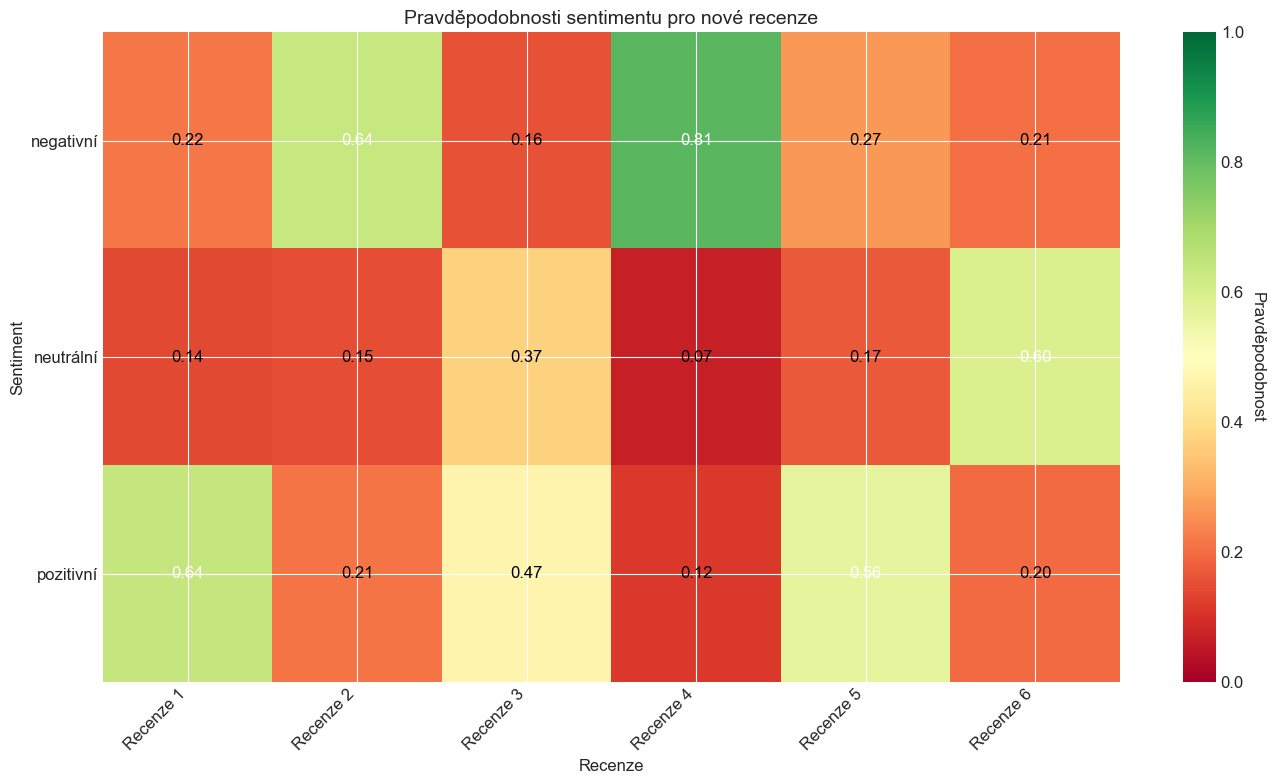

ANALÝZA SENTIMENTU NOVÝCH RECENZÍ

Recenze 1: Absolutně fantastický produkt! Překonal všechna očekávání!
Predikovaný sentiment: POZITIVNÍ
Pravděpodobnosti:
  negativní: 21.68%
  neutrální: 14.26%
  pozitivní: 64.06%
Důvěra: 64.06%

Recenze 2: Totální zklamání. Nefunguje vůbec.
Predikovaný sentiment: NEGATIVNÍ
Pravděpodobnosti:
  negativní: 63.52%
  neutrální: 15.00%
  pozitivní: 21.48%
Důvěra: 63.52%

Recenze 3: Je to OK, nic moc, ale ujde to.
Predikovaný sentiment: POZITIVNÍ
Pravděpodobnosti:
  negativní: 15.76%
  neutrální: 37.48%
  pozitivní: 46.76%
Důvěra: 46.76%

Recenze 4: Velmi špatná kvalita. Nedoporučuji.
Predikovaný sentiment: NEGATIVNÍ
Pravděpodobnosti:
  negativní: 81.42%
  neutrální: 7.03%
  pozitivní: 11.55%
Důvěra: 81.42%

Recenze 5: Skvělý poměr cena/výkon. Spokojenost.
Predikovaný sentiment: POZITIVNÍ
Pravděpodobnosti:
  negativní: 26.75%
  neutrální: 16.87%
  pozitivní: 56.38%
Důvěra: 56.38%

Recenze 6: Průměrný produkt za průměrnou cenu.
Predikovaný sentiment: NEUTRÁ

In [10]:
# Test sentimentu na nových recenzích
def test_sentiment_analysis(clf, vectorizer):
    new_reviews = [
        "Absolutně fantastický produkt! Překonal všechna očekávání!",
        "Totální zklamání. Nefunguje vůbec.",
        "Je to OK, nic moc, ale ujde to.",
        "Velmi špatná kvalita. Nedoporučuji.",
        "Skvělý poměr cena/výkon. Spokojenost.",
        "Průměrný produkt za průměrnou cenu."
    ]
    
    # Předzpracování a predikce
    processed = [preprocess_text(review) for review in new_reviews]
    X_new = vectorizer.transform(processed)
    predictions = clf.predict(X_new)
    probabilities = clf.predict_proba(X_new)
    
    # Vizualizace výsledků
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Heatmapa pravděpodobností
    prob_matrix = probabilities.T
    
    im = ax.imshow(prob_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    # Nastavení os
    ax.set_xticks(range(len(new_reviews)))
    ax.set_xticklabels([f'Recenze {i+1}' for i in range(len(new_reviews))], 
                      rotation=45, ha='right')
    ax.set_yticks(range(len(clf.classes_)))
    ax.set_yticklabels(clf.classes_)
    
    # Přidání hodnot do buněk
    for i in range(len(clf.classes_)):
        for j in range(len(new_reviews)):
            text = ax.text(j, i, f'{prob_matrix[i, j]:.2f}',
                          ha='center', va='center',
                          color='white' if prob_matrix[i, j] > 0.5 else 'black')
    
    ax.set_title('Pravděpodobnosti sentimentu pro nové recenze', fontsize=14)
    ax.set_ylabel('Sentiment')
    ax.set_xlabel('Recenze')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Pravděpodobnost', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()
    
    # Detailní výpis
    print("="*80)
    print("ANALÝZA SENTIMENTU NOVÝCH RECENZÍ")
    print("="*80)
    for i, (review, pred, probs) in enumerate(zip(new_reviews, predictions, probabilities)):
        print(f"\nRecenze {i+1}: {review}")
        print(f"Predikovaný sentiment: {pred.upper()}")
        print("Pravděpodobnosti:")
        for j, class_name in enumerate(clf.classes_):
            print(f"  {class_name}: {probs[j]:.2%}")
        print(f"Důvěra: {max(probs):.2%}")

# Test nových recenzí
test_sentiment_analysis(sentiment_clf, sentiment_vec)

## 6. Interaktivní aplikace

### 6.1 Gradio aplikace pro spam filtr a analýzu sentimentu

In [ ]:
# Interaktivní aplikace
def create_naive_bayes_app():
    # Příprava modelů
    # Spam filtr
    emails, labels = create_email_dataset()
    spam_vec = TfidfVectorizer(max_features=100)
    X_spam = spam_vec.fit_transform([preprocess_text(e) for e in emails])
    spam_clf = MultinomialNB()
    spam_clf.fit(X_spam, labels)
    
    # Sentiment analyzer
    reviews, sentiments = create_sentiment_dataset()
    sent_vec = TfidfVectorizer(ngram_range=(1, 2), max_features=200)
    X_sent = sent_vec.fit_transform([preprocess_text(r) for r in reviews])
    sent_clf = MultinomialNB()
    sent_clf.fit(X_sent, sentiments)
    
    def analyze_text(text, analysis_type):
        processed = preprocess_text(text)
        
        if analysis_type == "Spam Filter":
            X = spam_vec.transform([processed])
            clf = spam_clf
            vec = spam_vec
            classes = ['ham', 'spam']
            title = "Spam Analysis"
        else:
            X = sent_vec.transform([processed])
            clf = sent_clf
            vec = sent_vec
            classes = list(clf.classes_)
            title = "Sentiment Analysis"
        
        # Predikce
        prediction = clf.predict(X)[0]
        probabilities = clf.predict_proba(X)[0]
        
        # Vytvoření grafu
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Graf 1: Pravděpodobnosti
        colors = ['green' if c == 'ham' or c == 'pozitivní' else 
                 'red' if c == 'spam' or c == 'negativní' else 
                 'gray' for c in classes]
        
        bars = ax1.bar(classes, probabilities, color=colors, alpha=0.7)
        ax1.set_ylim(0, 1)
        ax1.set_ylabel('Pravděpodobnost')
        ax1.set_title(f'{title} - Výsledky', fontsize=14)
        
        # Přidání hodnot
        for bar, prob in zip(bars, probabilities):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{prob:.2%}', ha='center', va='bottom')
        
        # Graf 2: Důležitá slova
        # Získání příznaků textu
        feature_names = vec.get_feature_names_out()
        tfidf_scores = X.toarray()[0]
        
        # Nenulové příznaky
        nonzero_indices = np.where(tfidf_scores > 0)[0]
        if len(nonzero_indices) > 0:
            words = [feature_names[i] for i in nonzero_indices]
            scores = [tfidf_scores[i] for i in nonzero_indices]
            
            # Seřazení podle důležitosti
            sorted_indices = np.argsort(scores)[::-1][:10]
            top_words = [words[i] for i in sorted_indices]
            top_scores = [scores[i] for i in sorted_indices]
            
            ax2.barh(range(len(top_words)), top_scores, color='steelblue', alpha=0.7)
            ax2.set_yticks(range(len(top_words)))
            ax2.set_yticklabels(top_words)
            ax2.set_xlabel('TF-IDF skóre')
            ax2.set_title('Důležitá slova v textu', fontsize=14)
            ax2.grid(True, alpha=0.3)
        else:
            ax2.text(0.5, 0.5, 'Žádná významná slova nenalezena',
                    ha='center', va='center', fontsize=12)
            ax2.axis('off')
        
        plt.tight_layout()
        
        # Textový výstup
        result_text = f"""## Výsledky analýzy

**Typ analýzy:** {analysis_type}
**Predikce:** {prediction.upper()}
**Důvěra:** {max(probabilities):.1%}

### Pravděpodobnosti:
"""
        for class_name, prob in zip(classes, probabilities):
            result_text += f"- {class_name}: {prob:.2%}\n"
        
        if analysis_type == "Spam Filter":
            if prediction == 'spam':
                result_text += "\n⚠️ **Varování:** Tento text byl klasifikován jako SPAM!"
            else:
                result_text += "\n✅ **OK:** Tento text vypadá jako legitimní zpráva."
        else:
            emoji = "😊" if prediction == 'pozitivní' else "😞" if prediction == 'negativní' else "😐"
            result_text += f"\n{emoji} **Sentiment:** {prediction.capitalize()}"
        
        return fig, result_text
    
    # Vytvoření Gradio interface
    with gr.Blocks(title="Naivní Bayes Analyzer") as demo:
        gr.Markdown("# 🤖 Naivní Bayesův klasifikátor")
        gr.Markdown("""Analyzujte text pomocí Naivního Bayesova klasifikátoru.
        Můžete detekovat spam nebo analyzovat sentiment textu.""")
        
        with gr.Row():
            with gr.Column():
                text_input = gr.Textbox(
                    label="Zadejte text k analýze",
                    placeholder="Ahoj, bavili jsme se naposledy na schůzce o nějaké té akci ke Dnům AI, případně k Týdnu inovací, že by ses mohl spoluúčastnit. Romča Černíková je krajským koordinátorem ke Dnům AI a prý ses někam registroval, tak ti psala e-mail. Můžu jí dát Tvoje tel. číslo, ať se spojíte, nebo jí odpovíš na e-mail?",
                    lines=5
                )
                
                analysis_type = gr.Radio(
                    choices=["Spam Filter", "Sentiment Analysis"],
                    value="Spam Filter",
                    label="Typ analýzy"
                )
                
                analyze_btn = gr.Button("🔍 Analyzovat", variant="primary")
                
                # Příklady
                gr.Examples(
                    examples=[
                        ["Vyhrajte milion korun! Klikněte zde pro více informací!", "Spam Filter"],
                        ["Děkuji za váš email. Odpovím co nejdříve.", "Spam Filter"],
                        ["Tento produkt je absolutně skvělý! Velmi doporučuji!", "Sentiment Analysis"],
                        ["Zklamání. Produkt vůbec nefunguje.", "Sentiment Analysis"]
                    ],
                    inputs=[text_input, analysis_type]
                )
            
            with gr.Column():
                output_text = gr.Markdown("### Výsledky se zobrazí zde...")
        
        output_plot = gr.Plot(label="Vizualizace")
        
        analyze_btn.click(
            analyze_text,
            inputs=[text_input, analysis_type],
            outputs=[output_plot, output_text]
        )
        
        gr.Markdown("""### 📚 O Naivním Bayesově klasifikátoru
        
Naivní Bayesův klasifikátor je pravděpodobnostní klasifikátor založený na Bayesově větě
s "naivním" předpokladem nezávislosti mezi příznaky. I přes tento zjednodušující předpoklad
dosahuje často velmi dobrých výsledků, zejména při:

- **Klasifikaci textu** (spam filtrování, analýza sentimentu)
- **Kategorizaci dokumentů**
- **Predikci s omezenými daty**

**Výhody:**
- Rychlé učení a predikce
- Funguje dobře i s málo daty
- Poskytuje pravděpodobnosti pro každou třídu
- Odolný vůči irelevantním příznakům
        """)
    
    return demo

# Spuštění aplikace
app = create_naive_bayes_app()
app.launch(share=True)

* Running on local URL:  http://127.0.0.1:7863
* Running on public URL: https://7317f84e2d606b3149.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 7. Shrnutí a klíčové koncepty

### Co jsme se naučili:

1. **Princip Naivního Bayese**
   - Založen na Bayesově větě
   - "Naivní" předpoklad nezávislosti příznaků
   - Výpočetně efektivní

2. **Varianty podle typu dat**
   - **Gaussovský NB** - spojité příznaky
   - **Multinomiální NB** - počty/frekvence
   - **Bernoulliho NB** - binární příznaky

3. **Praktické aplikace**
   - Spam filtrování
   - Analýza sentimentu
   - Klasifikace dokumentů

4. **Výhody a nevýhody**
   - ✅ Rychlý a efektivní
   - ✅ Funguje i s málo daty
   - ✅ Poskytuje pravděpodobnosti
   - ❌ Předpoklad nezávislosti často nerealistický
   - ❌ Může být příliš jednoduchý pro komplexní data

## 8. Domácí úkol

### Úkol 1: Vylepšený spam filtr
Rozšiřte spam filtr o:
- Detekci velkých písmen (CAPS)
- Počet výkřičníků
- Délku emailu
- Přítomnost URL

### Úkol 2: Vícejazyčná analýza sentimentu
Implementujte analýzu sentimentu, která:
- Detekuje jazyk textu
- Používá odpovídající model
- Vizualizuje výsledky

### Úkol 3: Porovnání s jinými klasifikátory
Porovnejte Naivní Bayes s:
- Logistickou regresí
- Rozhodovacím stromem
- SVM
Na stejných datech a vizualizujte rozdíly

### Bonusový úkol: Real-time klasifikátor
Vytvořte aplikaci, která:
- Klasifikuje text během psaní
- Zobrazuje pravděpodobnosti v reálném čase
- Učí se z oprav uživatele

---

💡 **Tip**: Naivní Bayes je skvělý začátek pro klasifikaci textu. Experimentujte s různými způsoby předzpracování a výběru příznaků!